# 3회차 실습 과제: 추정과 가설검정 — 정답

## 문제 항목

| 문제     | 주제                 | 핵심 개념                                       |
|----------|----------------------|-------------------------------------------------|
| 문제 1   | 신뢰구간 계산        | 점추정, 구간추정, 신뢰수준, 표본크기 결정        |
| 문제 2   | 단일표본 검정        | 가설 설정, t-검정, p-value 해석, 결론 도출       |
| 문제 3   | 두 그룹 비교         | 독립표본 t-검정, 효과크기, 단일 vs 독립 vs 대응 구분     |
| 문제 4   | 전후 비교   | 대응표본 t-검정, 검정력   |

---

## 핵심 공식 정리

### 신뢰구간

| 조건              | 공식                                                             |
|-------------------|------------------------------------------------------------------|
| σ를 아는 경우     | $\bar{X} \pm z_{\alpha/2} \cdot \frac{\sigma}{\sqrt{n}}$       |
| σ를 모르는 경우   | $\bar{X} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$      |
| 필요 표본크기     | $n = \left(\frac{z_{\alpha/2} \cdot \sigma}{E}\right)^2$       |

### 검정통계량

| 검정               | 공식                                                                             |
|--------------------|----------------------------------------------------------------------------------|
| z-검정             | $z = \frac{\bar{X} - \mu_0}{\sigma / \sqrt{n}}$                                |
| 단일표본 t-검정    | $t = \frac{\bar{X} - \mu_0}{s / \sqrt{n}}, \quad df = n - 1$                   |
| 독립표본 t-검정    | $t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{s_1^2/n_1 + s_2^2/n_2}}$              |
| 대응표본 t-검정    | $t = \frac{\bar{d}}{s_d / \sqrt{n}}, \quad d_i = X_{after} - X_{before}$       |
| Cohen's d          | $d = \frac{|\bar{X}_1 - \bar{X}_2|}{s_{pooled}}$                               |

### scipy.stats 핵심 함수

| 함수                          | 설명                           | 사용 예시                                    |
|-------------------------------|--------------------------------|----------------------------------------------|
| `stats.t.interval()`         | t분포 기반 신뢰구간            | `stats.t.interval(0.95, df, loc, scale)`     |
| `stats.t.ppf()`              | t분포 임계값                   | `stats.t.ppf(0.975, df=29)`                 |
| `stats.ttest_1samp()`        | 단일표본 t-검정                | `stats.ttest_1samp(data, popmean=100)`       |
| `stats.ttest_ind()`          | 독립표본 t-검정                | `stats.ttest_ind(a, b, equal_var=False)`     |
| `stats.ttest_rel()`          | 대응표본 t-검정                | `stats.ttest_rel(after, before)`             |
| `stats.sem()`                | 표준오차 계산                  | `stats.sem(data)`                            |

### 판정 규칙

| p-value 결과  | 판정             | 해석                                          |
|---------------|------------------|-----------------------------------------------|
| p ≤ α         | H0 **기각**      | "이 결과가 우연이라고 보기 어렵습니다" → 유의   |
| p > α         | H0 **기각 실패** | "증거 부족, 판단 보류" (H0가 참은 아닙니다!)    |

---

In [1]:
# 필수 라이브러리 Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import platform

warnings.filterwarnings('ignore')

# seaborn 테마를 먼저 설정한 뒤 한글 폰트를 덮어써야 초기화되지 않습니다
sns.set_style('whitegrid')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

print("=" * 60)
print("3회차 실습 과제: 추정과 가설검정")
print("=" * 60)


3회차 실습 과제: 추정과 가설검정


---

## 문제 1: 신뢰구간 계산

### 시나리오: 배달 앱 배달 시간 분석

배달 앱 운영팀이 평균 배달 시간을 파악하려 합니다.

40건의 배달 데이터를 수집했습니다.

**주어진 데이터:**

In [2]:
print("\n[문제 1] 배달 앱 배달 시간 분석")
print("=" * 50)

np.random.seed(42)
delivery_times = np.random.normal(loc=35, scale=8, size=40)
delivery_times = np.round(delivery_times, 1)

print(f"배달 시간 데이터 (n = {len(delivery_times)}건):")
print(delivery_times)



[문제 1] 배달 앱 배달 시간 분석
배달 시간 데이터 (n = 40건):
[39.  33.9 40.2 47.2 33.1 33.1 47.6 41.1 31.2 39.3 31.3 31.3 36.9 19.7
 21.2 30.5 26.9 37.5 27.7 23.7 46.7 33.2 35.5 23.6 30.6 35.9 25.8 38.
 30.2 32.7 30.2 49.8 34.9 26.5 41.6 25.2 36.7 19.3 24.4 36.6]


### 문제 1-1: 점추정

**(a)** 모평균의 점추정값(표본평균)을 구하세요.

**(b)** 모표준편차의 점추정값(표본표준편차, ddof=1)을 구하세요.

**(c)** 표준오차(SE)를 구하세요.

In [3]:
print("\n[문제 1-1] 점추정")
print("-" * 40)

# pandas Series로 변환하면 mean/std/sem 메서드를 바로 사용할 수 있습니다
ds = pd.Series(delivery_times, name='배달시간')

# (a) 표본평균 — pd.Series.mean()
x_bar = ds.mean()
print(f"(a) 표본평균 = {x_bar:.2f}분")

# (b) 표본표준편차 — pd.Series.std() (pandas는 ddof=1이 기본값)
s = ds.std()
print(f"(b) 표본표준편차 = {s:.2f}분")

# (c) 표준오차 — pd.Series.sem() 또는 stats.sem()
se = ds.sem()
print(f"(c) 표준오차 SE = {se:.4f}분")




[문제 1-1] 점추정
----------------------------------------
(a) 표본평균 = 33.25분
(b) 표본표준편차 = 7.62분
(c) 표준오차 SE = 1.2050분


### 문제 1-2: 신뢰구간 구하기

**(a)** 95% 신뢰구간을 **수동으로** 계산하세요.

**(b)** `stats.t.interval()`를 사용하여 95% 신뢰구간을 구하세요.

**(c)** 90%, 95%, 99% 신뢰구간을 모두 구하고, 구간 너비를 비교하세요.

> 신뢰수준이 높아지면 구간 너비는 어떻게 변하나요?

In [4]:
print("\n[문제 1-2] 신뢰구간 구하기")
print("-" * 40)

n = len(delivery_times)
alpha = 0.05

# (a) 수동 계산: t 임계값 → 오차한계 → 신뢰구간
t_crit = stats.t.ppf(1 - alpha / 2, df=n - 1)
margin = t_crit * se
ci_low = x_bar - margin
ci_high = x_bar + margin

print(f"(a) 수동 계산:")
print(f"    t 임계값 (df={n-1}): {t_crit:.4f}")
print(f"    오차한계: ±{margin:.4f}")
print(f"    95% CI: [{ci_low:.2f}, {ci_high:.2f}]")


# (b) scipy.stats 활용
ci_scipy = stats.t.interval(0.95, df=n - 1, loc=x_bar, scale=se)

print(f"\n(b) scipy 활용:")
print(f"    95% CI: [{ci_scipy[0]:.2f}, {ci_scipy[1]:.2f}]")


# (c) 세 가지 신뢰수준 너비 비교 — DataFrame으로 정리
print(f"\n(c) 신뢰수준별 비교:")
ci_results = []
for confidence in [0.90, 0.95, 0.99]:
    ci = stats.t.interval(confidence, df=n - 1, loc=x_bar, scale=se)
    width = ci[1] - ci[0]
    ci_results.append({
        '신뢰수준': f"{confidence*100:.0f}%",
        '하한': round(ci[0], 2),
        '상한': round(ci[1], 2),
        '너비': round(width, 2)
    })
    print(f"    {confidence*100:.0f}% CI: [{ci[0]:.2f}, {ci[1]:.2f}]  (너비: {width:.2f})")

print("\n    해석: 신뢰수준이 높아질수록 구간 너비가 넓어집니다.")
print("    → 더 확신하려면 더 넓은 범위를 허용해야 하기 때문입니다 (Trade-off).")




[문제 1-2] 신뢰구간 구하기
----------------------------------------
(a) 수동 계산:
    t 임계값 (df=39): 2.0227
    오차한계: ±2.4374
    95% CI: [30.81, 35.68]

(b) scipy 활용:
    95% CI: [30.81, 35.68]

(c) 신뢰수준별 비교:
    90% CI: [31.21, 35.28]  (너비: 4.06)
    95% CI: [30.81, 35.68]  (너비: 4.87)
    99% CI: [29.98, 36.51]  (너비: 6.53)

    해석: 신뢰수준이 높아질수록 구간 너비가 넓어집니다.
    → 더 확신하려면 더 넓은 범위를 허용해야 하기 때문입니다 (Trade-off).


### 문제 1-3: 표본크기 결정

경영진이 "평균 배달 시간의 **오차한계를 ±1분 이내**로 하고 싶다"고 합니다.

**(a)** 95% 신뢰수준에서 필요한 최소 표본크기를 구하세요.

**(b)** 오차한계를 ±0.5분으로 줄이면 표본크기가 어떻게 변하나요?

In [5]:
print("\n[문제 1-3] 표본크기 결정")
print("-" * 40)

z_95 = 1.96
sigma_est = ds.std()  # 표본표준편차를 σ 추정치로 사용

# (a) 오차한계 ±1분 → n = (z * σ / E)^2 → 올림
E1 = 1.0
n_required_1 = int(np.ceil((z_95 * sigma_est / E1) ** 2))
print(f"(a) 오차한계 ±{E1}분 → 필요 표본크기: {n_required_1}건")

# (b) 오차한계 ±0.5분
E2 = 0.5
n_required_2 = int(np.ceil((z_95 * sigma_est / E2) ** 2))
print(f"(b) 오차한계 ±{E2}분 → 필요 표본크기: {n_required_2}건")

print(f"\n    해석: 오차한계를 절반으로 줄이면 필요 표본크기는 약 4배로 늘어납니다.")
print(f"    ({n_required_1}건 → {n_required_2}건, 약 {n_required_2/n_required_1:.1f}배)")



[문제 1-3] 표본크기 결정
----------------------------------------
(a) 오차한계 ±1.0분 → 필요 표본크기: 224건
(b) 오차한계 ±0.5분 → 필요 표본크기: 893건

    해석: 오차한계를 절반으로 줄이면 필요 표본크기는 약 4배로 늘어납니다.
    (224건 → 893건, 약 4.0배)


---

## 문제 2: 단일표본 t-검정

### 시나리오: 음료 자판기 용량 검사

자판기 제조사는 커피 한 잔의 용량이 **200ml**이라고 주장합니다.

소비자 보호원이 무작위로 20잔을 측정하여 주장을 검증합니다.

**주어진 데이터:**

In [6]:
print("\n[문제 2] 자판기 용량 검사")
print("=" * 50)

np.random.seed(123)
coffee_ml = np.random.normal(loc=196, scale=6, size=20)
coffee_ml = np.round(coffee_ml, 1)

# pandas Series로 기초통계 확인
coffee = pd.Series(coffee_ml, name='용량(ml)')

print(f"측정 데이터 (n = {len(coffee)}잔):")
print(coffee_ml)
print(f"\n표본평균: {coffee.mean():.2f}ml")
print(f"표본표준편차: {coffee.std():.2f}ml")




[문제 2] 자판기 용량 검사
측정 데이터 (n = 20잔):
[189.5 202.  197.7 187.  192.5 205.9 181.4 193.4 203.6 190.8 191.9 195.4
 204.9 192.2 193.3 193.4 209.2 209.1 202.  198.3]

표본평균: 196.68ml
표본표준편차: 7.54ml


### 문제 2-1: 가설검정 5단계

유의수준 α = 0.05에서, 자판기 용량이 200ml에 미달하는지 검정하세요.

**(a)** 가설을 설정하세요.

**(b)** `stats.ttest_1samp()`으로 검정통계량과 p-value를 구하세요.

**(c)** 결론을 내리세요. (기각 또는 기각 실패, 그 의미)

**(d)** 95% 신뢰구간(양측)을 구하고, 구간에 200이 포함되는지 확인하세요. 그래서 검정 결과와 일관되는지 확인 하세요.

In [7]:
print("\n[문제 2-1] 가설검정 5단계")
print("-" * 40)

mu_0 = 200  # 제조사 주장
alpha = 0.05

# (a) 가설 설정 — "미달하는지"이므로 좌측검정
print("[1단계] 가설 설정")
print(f"  H0: mu = {mu_0}  (주장대로 200ml)")
print(f"  H1: mu < {mu_0}  (200ml에 미달)")
print(f"  검정 유형: 좌측 단측검정")

print(f"\n[2단계] 유의수준: alpha = {alpha}")

# (b) 검정 실행 — ttest_1samp는 양측 p-value를 반환
t_stat, p_value_two = stats.ttest_1samp(coffee_ml, popmean=mu_0)

# 좌측검정이므로 p_value = p_양측/2 (t < 0일 때)
p_value = p_value_two / 2 if t_stat < 0 else 1 - p_value_two / 2

print(f"\n[3단계] 검정통계량")
print(f"  t-통계량: {t_stat:.4f}")

print(f"\n[4단계] p-value")
print(f"  p-value (양측): {p_value_two:.4f}")
print(f"  p-value (좌측): {p_value:.4f}")

# (c) 결론
print(f"\n[5단계] 결론")
if p_value <= alpha:
    print(f"  p-value({p_value:.4f}) ≤ α({alpha}) → H0 기각")
    print(f"  → 자판기 용량이 200ml에 미달한다는 통계적 증거가 있습니다.")
else:
    print(f"  p-value({p_value:.4f}) > α({alpha}) → H0 기각 실패")
    print(f"  → 자판기 용량이 200ml에 미달한다는 충분한 증거가 없습니다.")

# (d) 95% 신뢰구간
ci_95 = stats.t.interval(0.95, df=len(coffee_ml) - 1,
                         loc=coffee.mean(), scale=coffee.sem())

print(f"\n[참고] 95% 신뢰구간: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")

contains_200 = ci_95[0] <= 200 <= ci_95[1]
print(f"  200ml 포함 여부: {'포함' if contains_200 else '미포함'}")
if contains_200:
    print(f"  → 양측 95% CI에 200이 포함되어 있습니다.")
    print(f"    단측검정(좌측)에서는 기각되었지만, 양측 CI에 포함될 수 있습니다.")
    print(f"    이는 단측/양측 검정의 기준 차이 때문이며, 서로 모순은 아닙니다.")
else:
    print(f"  → 200이 신뢰구간 밖에 있으므로 검정 결과(H0 기각)와 일관됩니다.")




[문제 2-1] 가설검정 5단계
----------------------------------------
[1단계] 가설 설정
  H0: mu = 200  (주장대로 200ml)
  H1: mu < 200  (200ml에 미달)
  검정 유형: 좌측 단측검정

[2단계] 유의수준: alpha = 0.05

[3단계] 검정통계량
  t-통계량: -1.9723

[4단계] p-value
  p-value (양측): 0.0633
  p-value (좌측): 0.0317

[5단계] 결론
  p-value(0.0317) ≤ α(0.05) → H0 기각
  → 자판기 용량이 200ml에 미달한다는 통계적 증거가 있습니다.

[참고] 95% 신뢰구간: [193.15, 200.20]
  200ml 포함 여부: 포함
  → 양측 95% CI에 200이 포함되어 있습니다.
    단측검정(좌측)에서는 기각되었지만, 양측 CI에 포함될 수 있습니다.
    이는 단측/양측 검정의 기준 차이 때문이며, 서로 모순은 아닙니다.


### 문제 2-2: p-value 해석 연습

다음 각 상황에서 올바른 해석을 고르세요.

**(a)** p-value = 0.03, α = 0.05 일 때 올바른 해석은?

1. "H0가 참일 확률이 3%이다"

2. "H0가 참일 때, 이 결과가 나올 확률이 3%이다"

3. "H1이 참일 확률이 97%이다"

**(b)** p-value = 0.12, α = 0.05 일 때, "H0가 참이다"라고 결론 내릴 수 있나요?

**(c)** 같은 데이터로 α = 0.01과 α = 0.10을 적용하면 결론이 달라질 수 있는 예를 설명하세요.

In [8]:
print("\n[문제 2-2] p-value 해석 연습")
print("-" * 40)

# (a) 올바른 해석: 2번
answer_a = 2
print(f"(a) 올바른 해석: {answer_a}번")
print(f"    'H0가 참일 때, 이 결과(또는 더 극단적인 결과)가 나올 확률이 3%이다'")
print(f"    → 1번은 사후확률(H0가 참일 확률)이므로 틀립니다.")
print(f"    → 3번은 H1의 확률을 직접 말할 수 없으므로 틀립니다.")

# (b) H0 기각 실패 ≠ H0가 참
print(f"\n(b) p=0.12일 때 'H0가 참이다'라고 할 수 있나요?")
print(f"    아니요. '기각 실패'는 'H0가 참'을 의미하지 않습니다.")
print(f"    증거 부족으로 판단을 보류한 것일 뿐, H0가 참이라고 증명된 것은 아닙니다.")
print(f"    (비유: 무죄 판결 = 결백 증명이 아니라, 유죄 증거 부족)")

# (c) 유의수준에 따른 결론 차이
print(f"\n(c) 유의수준에 따른 결론 차이 예시:")
print(f"    예) p-value = 0.03인 경우:")
print(f"    - α = 0.10: p(0.03) < α(0.10) → H0 기각 (유의)")
print(f"    - α = 0.05: p(0.03) < α(0.05) → H0 기각 (유의)")
print(f"    - α = 0.01: p(0.03) > α(0.01) → H0 기각 실패 (유의하지 않음)")
print(f"    → 같은 데이터라도 유의수준 기준에 따라 결론이 달라질 수 있습니다.")





[문제 2-2] p-value 해석 연습
----------------------------------------
(a) 올바른 해석: 2번
    'H0가 참일 때, 이 결과(또는 더 극단적인 결과)가 나올 확률이 3%이다'
    → 1번은 사후확률(H0가 참일 확률)이므로 틀립니다.
    → 3번은 H1의 확률을 직접 말할 수 없으므로 틀립니다.

(b) p=0.12일 때 'H0가 참이다'라고 할 수 있나요?
    아니요. '기각 실패'는 'H0가 참'을 의미하지 않습니다.
    증거 부족으로 판단을 보류한 것일 뿐, H0가 참이라고 증명된 것은 아닙니다.
    (비유: 무죄 판결 = 결백 증명이 아니라, 유죄 증거 부족)

(c) 유의수준에 따른 결론 차이 예시:
    예) p-value = 0.03인 경우:
    - α = 0.10: p(0.03) < α(0.10) → H0 기각 (유의)
    - α = 0.05: p(0.03) < α(0.05) → H0 기각 (유의)
    - α = 0.01: p(0.03) > α(0.01) → H0 기각 실패 (유의하지 않음)
    → 같은 데이터라도 유의수준 기준에 따라 결론이 달라질 수 있습니다.


---

## 문제 3: 독립표본 t-검정

### 시나리오: 온라인 vs 오프라인 강의 효과 비교

교육 기관에서 온라인 강의와 오프라인 강의의 학습 효과를 비교합니다.

두 그룹은 서로 다른 학생들로 구성되어 있습니다 (독립표본).

**주어진 데이터:**

In [9]:
print("\n[문제 3] 온라인 vs 오프라인 강의 효과 비교")
print("=" * 50)

np.random.seed(42)
online = np.random.normal(loc=75, scale=12, size=35)   # 온라인 강의
offline = np.random.normal(loc=80, scale=10, size=30)   # 오프라인 강의

# DataFrame으로 기초통계 정리
df_scores = pd.DataFrame({
    '그룹': ['온라인'] * len(online) + ['오프라인'] * len(offline),
    '점수': np.concatenate([online, offline])
})

summary = df_scores.groupby('그룹')['점수'].agg(['count', 'mean', 'std']).round(2)
summary.columns = ['n', '평균', 'SD']
for grp, row in summary.iterrows():
    print(f"{grp} (n={int(row['n'])}): 평균={row['평균']:.2f}, SD={row['SD']:.2f}")



[문제 3] 온라인 vs 오프라인 강의 효과 비교
오프라인 (n=30): 평균=77.74, SD=8.72
온라인 (n=35): 평균=73.41, SD=11.18


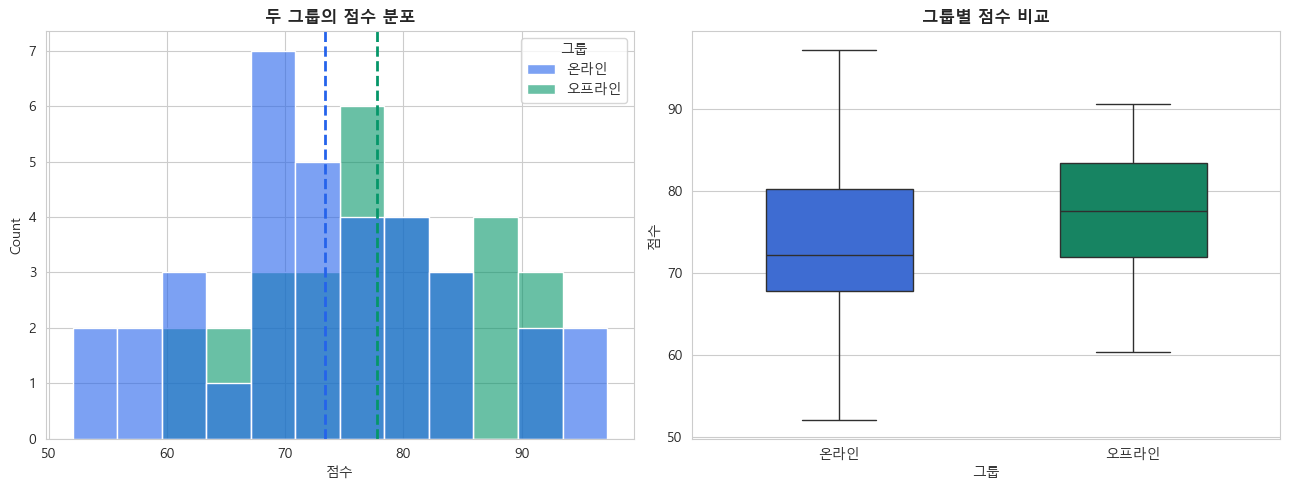

In [10]:
# 시각화: seaborn으로 두 그룹 비교
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# 히스토그램 — sns.histplot
sns.histplot(data=df_scores, x='점수', hue='그룹', bins=12,
             alpha=0.6, ax=axes[0], palette=['#2563EB', '#059669'])
for grp, color in zip(['온라인', '오프라인'], ['#2563EB', '#059669']):
    m = df_scores.loc[df_scores['그룹'] == grp, '점수'].mean()
    axes[0].axvline(m, color=color, linestyle='--', linewidth=2)
axes[0].set_title('두 그룹의 점수 분포', fontsize=12, fontweight='bold')

# 박스플롯 — sns.boxplot
sns.boxplot(data=df_scores, x='그룹', y='점수', palette=['#2563EB', '#059669'],
            ax=axes[1], width=0.5)
axes[1].set_title('그룹별 점수 비교', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


### 문제 3-1: 독립표본 t-검정 수행

**(a)** 가설을 설정하세요.

> 두 강의 방식의 효과에 차이가 있는지 (양측검정)

**(b)** `stats.ttest_ind()`로 검정하세요.

> `equal_var=False`를 사용하여 Welch's t-test를 수행하세요 (등분산 가정 없이).

**(c)** α = 0.05에서 결론을 내리세요.

In [11]:
print("\n[문제 3-1] 독립표본 t-검정")
print("-" * 40)

alpha = 0.05

# (a) 가설 설정
print("[가설 설정]")
print("  H0: μ_온라인 = μ_오프라인 (두 강의 효과가 같다)")
print("  H1: μ_온라인 ≠ μ_오프라인 (두 강의 효과가 다르다) → 양측검정")

# (b) Welch's t-test (등분산 가정 없이)
t_stat, p_value = stats.ttest_ind(online, offline, equal_var=False)

print(f"\n[검정 결과]")
print(f"  t-통계량: {t_stat:.4f}")
print(f"  p-value (양측): {p_value:.4f}")

# (c) 결론
print(f"\n[결론] (α = {alpha})")
if p_value <= alpha:
    print(f"  p-value({p_value:.4f}) ≤ α({alpha}) → H0 기각")
    print(f"  → 두 강의 방식의 학습 효과에 통계적으로 유의한 차이가 있습니다.")
else:
    print(f"  p-value({p_value:.4f}) > α({alpha}) → H0 기각 실패")
    print(f"  → 두 강의 방식의 학습 효과에 유의한 차이가 있다는 충분한 증거가 없습니다.")



[문제 3-1] 독립표본 t-검정
----------------------------------------
[가설 설정]
  H0: μ_온라인 = μ_오프라인 (두 강의 효과가 같다)
  H1: μ_온라인 ≠ μ_오프라인 (두 강의 효과가 다르다) → 양측검정

[검정 결과]
  t-통계량: -1.7515
  p-value (양측): 0.0848

[결론] (α = 0.05)
  p-value(0.0848) > α(0.05) → H0 기각 실패
  → 두 강의 방식의 학습 효과에 유의한 차이가 있다는 충분한 증거가 없습니다.


### 문제 3-2: 효과크기 (Cohen's d)

**(a)** Cohen's d를 계산하세요.

> 공식: $d = \frac{|\bar{X}_1 - \bar{X}_2|}{s_{pooled}}$
>
> $s_{pooled} = \sqrt{\frac{(n_1-1) s_1^2 + (n_2-1) s_2^2}{n_1 + n_2 - 2}}$

**(b)** 효과크기를 해석하세요. (작은/중간/큰 효과)

| d 값  | 해석      |
|-------|-----------|
| 0.2   | 작은 효과 |
| 0.5   | 중간 효과 |
| 0.8   | 큰 효과   |

**(c)** p-value 결과와 효과크기를 종합하여 최종 판단을 내리세요.

In [12]:
print("\n[문제 3-2] 효과크기 (Cohen's d)")
print("-" * 40)

n1, n2 = len(online), len(offline)
s1 = np.std(online, ddof=1)
s2 = np.std(offline, ddof=1)

# (a) Cohen's d 계산 — 합동표준편차(pooled SD) 사용
s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
cohens_d = abs(np.mean(online) - np.mean(offline)) / s_pooled

print(f"(a) Cohen's d 계산:")
print(f"    s_pooled = {s_pooled:.4f}")
print(f"    Cohen's d = {cohens_d:.4f}")

# (b) 해석
def interpret_d(d):
    """Cohen's d 해석"""
    if d < 0.2: return "무시할 수준"
    elif d < 0.5: return "작은 효과"
    elif d < 0.8: return "중간 효과"
    else: return "큰 효과"

print(f"\n(b) 효과크기 해석: {interpret_d(cohens_d)}")

# (c) 종합 판단
print(f"\n(c) 종합 판단:")
print(f"    - p-value = {p_value:.4f} → {'유의함' if p_value <= alpha else '유의하지 않음'}")
print(f"    - Cohen's d = {cohens_d:.4f} → {interpret_d(cohens_d)}")
if p_value > alpha and cohens_d >= 0.5:
    print(f"    → 통계적으로 유의하지 않지만 효과크기가 {interpret_d(cohens_d)}이므로,")
    print(f"      표본 크기를 늘려 재검정하면 유의한 결과가 나올 가능성이 있습니다.")
elif p_value <= alpha and cohens_d < 0.2:
    print(f"    → 통계적으로 유의하지만 실질적 차이는 무시할 수준입니다.")
elif p_value <= alpha:
    print(f"    → 통계적으로 유의하며, 실질적으로도 의미 있는 차이입니다.")
else:
    print(f"    → 통계적으로도, 실질적으로도 두 강의 방식의 뚜렷한 차이를 확인하기 어렵습니다.")



[문제 3-2] 효과크기 (Cohen's d)
----------------------------------------
(a) Cohen's d 계산:
    s_pooled = 10.1224
    Cohen's d = 0.4276

(b) 효과크기 해석: 작은 효과

(c) 종합 판단:
    - p-value = 0.0848 → 유의하지 않음
    - Cohen's d = 0.4276 → 작은 효과
    → 통계적으로도, 실질적으로도 두 강의 방식의 뚜렷한 차이를 확인하기 어렵습니다.


### 문제 3-3: 적절한 t검정 선택

아래 각 상황에서 어느 검정을 사용해야 하는지 고르고, 그 이유를 간단히 적어보세요.

**보기**: 단일표본 t-검정 / 독립표본 t-검정(Student's) / 독립표본 t-검정(Welch's) / 대응표본 t-검정

**(a)** 제과업체에서 과자 1봉지의 규격 중량은 150g입니다. 생산라인에서 12봉지를 샘플링하여 규격에 맞는지 확인하려 합니다.

**(b)** A반(30명)과 B반(28명) 학생들의 수학 점수 차이를 비교 (두 반의 분산이 비슷함)

**(c)** A공장(25개)과 B공장(30개) 배터리 수명을 비교하려 하는데, 두 공장의 분산이 같은지 모릅니다.

**(d)** 같은 환자 20명에게 치료 전후 혈압을 측정하여 치료 효과를 검증

**(e)** 만약 (d)의 데이터를 독립표본 t-검정으로 잘못 분석하면 어떤 문제가 생기나요?

In [13]:
print("\n[문제 3-3] 적절한 t검정 선택")
print("-" * 40)
print("보기: 단일표본 t-검정 / 독립표본 t-검정(Student's) /")
print("      독립표본 t-검정(Welch's) / 대응표본 t-검정")

# (a)
print("\n(a) 제과업체에서 과자 1봉지의 규격 중량은 150g입니다.")
print("    생산라인에서 12봉지를 샘플링하여 규격에 맞는지 확인하려 합니다.")
print(f"    사용할 검정: 단일표본 t-검정")
print(f"    이유: 하나의 표본 평균을 기준값(150g)과 비교하는 상황입니다.")

# (b)
print("\n(b) A반(30명)과 B반(28명) 학생들의 수학 점수 차이를 비교")
print("    (두 반의 분산이 비슷함)")
print(f"    사용할 검정: 독립표본 t-검정(Student's)")
print(f"    이유: 서로 다른 두 그룹이고, 분산이 비슷하다고 알려져 있으므로")
print(f"          등분산 가정이 가능합니다. (Welch's도 사용 가능)")

# (c)
print("\n(c) A공장(25개)과 B공장(30개) 배터리 수명을 비교하려 하는데,")
print("    두 공장의 분산이 같은지 모릅니다.")
print(f"    사용할 검정: 독립표본 t-검정(Welch's)")
print(f"    이유: 서로 다른 두 그룹이고, 분산이 같은지 모르므로")
print(f"          등분산 가정 없이 Welch's t-test를 사용합니다.")

# (d)
print("\n(d) 같은 환자 20명에게 치료 전후 혈압을 측정하여 치료 효과를 검증")
print(f"    사용할 검정: 대응표본 t-검정")
print(f"    이유: 같은 대상의 전후 측정이므로 짝지어진(paired) 데이터입니다.")

# (e)
print("\n(e) 만약 (d)의 데이터를 독립표본 t-검정으로 잘못 분석하면")
print("    어떤 문제가 생기나요?")
print(f"    문제점: 개인 간 변동(개인차)이 오차에 포함되어 분산이 과대추정됩니다.")
print(f"    → 검정력이 떨어져 실제 효과가 있어도 탐지하지 못할 가능성이 높아집니다.")
print(f"    대응표본 검정은 개인차를 제거하므로 더 민감하게 효과를 탐지할 수 있습니다.")



[문제 3-3] 적절한 t검정 선택
----------------------------------------
보기: 단일표본 t-검정 / 독립표본 t-검정(Student's) /
      독립표본 t-검정(Welch's) / 대응표본 t-검정

(a) 제과업체에서 과자 1봉지의 규격 중량은 150g입니다.
    생산라인에서 12봉지를 샘플링하여 규격에 맞는지 확인하려 합니다.
    사용할 검정: 단일표본 t-검정
    이유: 하나의 표본 평균을 기준값(150g)과 비교하는 상황입니다.

(b) A반(30명)과 B반(28명) 학생들의 수학 점수 차이를 비교
    (두 반의 분산이 비슷함)
    사용할 검정: 독립표본 t-검정(Student's)
    이유: 서로 다른 두 그룹이고, 분산이 비슷하다고 알려져 있으므로
          등분산 가정이 가능합니다. (Welch's도 사용 가능)

(c) A공장(25개)과 B공장(30개) 배터리 수명을 비교하려 하는데,
    두 공장의 분산이 같은지 모릅니다.
    사용할 검정: 독립표본 t-검정(Welch's)
    이유: 서로 다른 두 그룹이고, 분산이 같은지 모르므로
          등분산 가정 없이 Welch's t-test를 사용합니다.

(d) 같은 환자 20명에게 치료 전후 혈압을 측정하여 치료 효과를 검증
    사용할 검정: 대응표본 t-검정
    이유: 같은 대상의 전후 측정이므로 짝지어진(paired) 데이터입니다.

(e) 만약 (d)의 데이터를 독립표본 t-검정으로 잘못 분석하면
    어떤 문제가 생기나요?
    문제점: 개인 간 변동(개인차)이 오차에 포함되어 분산이 과대추정됩니다.
    → 검정력이 떨어져 실제 효과가 있어도 탐지하지 못할 가능성이 높아집니다.
    대응표본 검정은 개인차를 제거하므로 더 민감하게 효과를 탐지할 수 있습니다.


---

## 문제 4: 대응표본 t-검정과 검정력

### 시나리오: 영어 학습 앱 효과 검증

교육 회사가 새로운 영어 학습 앱의 효과를 검증합니다.

15명의 학생이 앱 사용 전후에 영어 시험을 치렀습니다.

**주어진 데이터:**

In [14]:
print("\n[문제 4] 영어 학습 앱 효과 검증")
print("=" * 50)

np.random.seed(42)
n_students = 15

before_scores = np.random.normal(loc=65, scale=10, size=n_students)
improvement = np.random.normal(loc=5, scale=6, size=n_students)
after_scores = before_scores + improvement

before_scores = np.round(before_scores, 1)
after_scores = np.round(after_scores, 1)

# DataFrame으로 정리
df_paired = pd.DataFrame({
    '학생': range(1, n_students + 1),
    '사전': before_scores,
    '사후': after_scores,
})
df_paired['변화'] = df_paired['사후'] - df_paired['사전']

print(f"{'학생':>4} {'사전':>8} {'사후':>8} {'변화':>8}")
print("-" * 32)
for _, row in df_paired.iterrows():
    print(f"  {int(row['학생']):>2d}   {row['사전']:>6.1f}   {row['사후']:>6.1f}   {row['변화']:>+6.1f}")
print(f"\n사전 평균: {df_paired['사전'].mean():.2f}")
print(f"사후 평균: {df_paired['사후'].mean():.2f}")
print(f"차이 평균: {df_paired['변화'].mean():.2f}")




[문제 4] 영어 학습 앱 효과 검증
  학생       사전       사후       변화
--------------------------------
   1     70.0     71.6     +1.6
   2     63.6     62.5     -1.1
   3     71.5     78.4     +6.9
   4     80.2     79.8     -0.4
   5     62.7     59.2     -3.5
   6     62.7     76.5    +13.8
   7     80.8     84.4     +3.6
   8     72.7     78.1     +5.4
   9     60.3     56.8     -3.5
  10     70.4     72.2     +1.8
  11     60.4     66.0     +5.6
  12     60.3     58.4     -1.9
  13     67.4     74.7     +7.3
  14     45.9     47.3     +1.4
  15     47.8     51.0     +3.2

사전 평균: 65.11
사후 평균: 67.79
차이 평균: 2.68


### 문제 4-1: 대응표본 t-검정

**(a)** 가설을 설정하세요.

**(b)** 검정을 수행하세요.

**(c)** α = 0.05에서 결론을 내리세요.

**(d)** 차이(d = 사후 - 사전)의 95% 신뢰구간을 구하세요.

In [15]:
print("\n[문제 4-1] 대응표본 t-검정")
print("-" * 40)

alpha = 0.05
differences = after_scores - before_scores

# (a) 가설 설정 — "효과가 있는지" = 점수가 올랐는지 → 우측검정
print("[가설 설정]")
print("  H0: μ_d = 0  (앱 사용 효과 없음, 전후 차이 없음)")
print("  H1: μ_d > 0  (앱 사용 후 점수 향상) → 우측검정")

# (b) 대응표본 t-검정 — alternative='greater' 사용
t_stat, p_value = stats.ttest_rel(after_scores, before_scores, alternative='greater')

print(f"\n[검정 결과]")
print(f"  t-통계량: {t_stat:.4f}")
print(f"  p-value (우측): {p_value:.4f}")

# (c) 결론
print(f"\n[결론] (α = {alpha})")
if p_value <= alpha:
    print(f"  p-value({p_value:.4f}) ≤ α({alpha}) → H0 기각")
    print(f"  → 앱 사용 후 점수가 통계적으로 유의하게 향상되었습니다.")
else:
    print(f"  p-value({p_value:.4f}) > α({alpha}) → H0 기각 실패")
    print(f"  → 앱 사용 효과가 있다는 충분한 증거가 없습니다.")

# (d) 차이의 95% 신뢰구간
d_series = pd.Series(differences)
ci_diff = stats.t.interval(0.95, df=n_students - 1,
                           loc=d_series.mean(), scale=d_series.sem())

print(f"\n[차이의 95% 신뢰구간]")
print(f"  차이 평균: {d_series.mean():.2f}")
print(f"  차이 SD:   {d_series.std():.2f}")
print(f"  95% CI: [{ci_diff[0]:.2f}, {ci_diff[1]:.2f}]")

if ci_diff[0] > 0:
    print(f"  → 구간 전체가 0보다 크므로, 향상 효과가 있다고 볼 수 있습니다.")
elif ci_diff[1] < 0:
    print(f"  → 구간 전체가 0보다 작으므로, 오히려 감소했다고 볼 수 있습니다.")
else:
    print(f"  → 구간이 0을 포함하므로, 효과 유무를 확신하기 어렵습니다.")




[문제 4-1] 대응표본 t-검정
----------------------------------------
[가설 설정]
  H0: μ_d = 0  (앱 사용 효과 없음, 전후 차이 없음)
  H1: μ_d > 0  (앱 사용 후 점수 향상) → 우측검정

[검정 결과]
  t-통계량: 2.2254
  p-value (우측): 0.0215

[결론] (α = 0.05)
  p-value(0.0215) ≤ α(0.05) → H0 기각
  → 앱 사용 후 점수가 통계적으로 유의하게 향상되었습니다.

[차이의 95% 신뢰구간]
  차이 평균: 2.68
  차이 SD:   4.66
  95% CI: [0.10, 5.26]
  → 구간 전체가 0보다 크므로, 향상 효과가 있다고 볼 수 있습니다.


### 문제 4-2 (도전!) : 검정력 분석

앱의 실제 효과가 **평균 5점 향상**이라고 가정합니다.

현재 표본(n=15)으로 이 효과를 탐지할 수 있는 확률(검정력)은 얼마인가요?

> 힌트: `TTestPower.solve_power()`를 사용하세요. effect_size에는 Cohen's d = mu_d / s_d 를 넣어야 합니다.

**(a)** 현재 표본크기(n=15)에서의 검정력을 계산하세요.

**(b)** 80% 검정력을 달성하려면 최소 몇 명이 필요한가요?

**(c)** 검정력 곡선을 그리세요. (x축: 표본크기 n, y축: 검정력 Power)

> 힌트: n을 5~100 범위로 변화시키며 각각의 검정력을 계산하고, 80% 기준선도 함께 표시하세요.

In [16]:
print("\n[문제 4-2] 검정력 분석")
print("-" * 40)

from statsmodels.stats.power import TTestPower

# 가정
mu_d = 5           # 가정한 평균 차이 (점)
s_d = np.std(differences, ddof=1)  # 차이의 표준편차

print(f"가정: 실제 효과 = {mu_d}점 향상")
print(f"차이의 표준편차 sd = {s_d:.2f}")

# Cohen's d = 기대 효과 / 표준편차
d = mu_d / s_d
print(f"Cohen's d = {mu_d} / {s_d:.2f} = {d:.4f}")

analysis = TTestPower()

# (a) 현재 검정력 (n=15)
# solve_power에 effect_size, nobs, alpha 3개를 주면 power를 역산합니다
power_current = analysis.solve_power(
    effect_size=d,
    nobs=n_students,
    alpha=alpha,
    alternative='larger'   # 우측검정
)
print(f"\n(a) 현재 검정력 (n={n_students}): {power_current:.4f} ({power_current*100:.1f}%)")

# (b) 80% 검정력에 필요한 표본크기
# effect_size, power, alpha 3개를 주면 nobs를 역산합니다
n_required = analysis.solve_power(
    effect_size=d,
    power=0.80,
    alpha=alpha,
    alternative='larger'
)
n_required = int(np.ceil(n_required))
print(f"(b) 80% 검정력 달성에 필요한 최소 표본크기: {n_required}명")



[문제 4-2] 검정력 분석
----------------------------------------
가정: 실제 효과 = 5점 향상
차이의 표준편차 sd = 4.66
Cohen's d = 5 / 4.66 = 1.0720

(a) 현재 검정력 (n=15): 0.9891 (98.9%)
(b) 80% 검정력 달성에 필요한 최소 표본크기: 7명


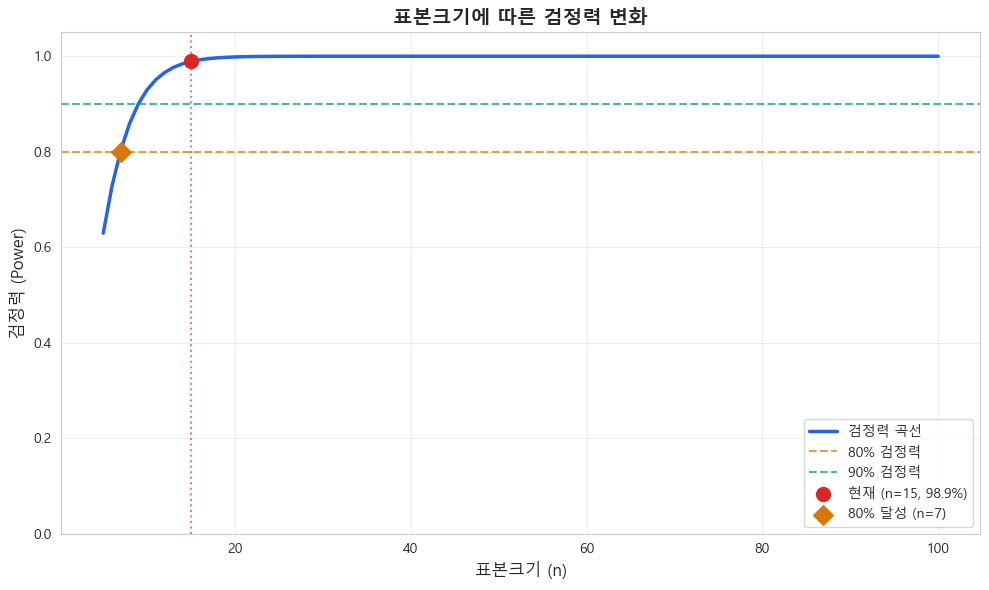

In [17]:
# (c) 검정력 곡선 시각화
fig, ax = plt.subplots(figsize=(10, 6))

n_range = np.arange(5, 101)
powers = [
    analysis.solve_power(effect_size=d, nobs=n, alpha=alpha, alternative='larger')
    for n in n_range
]

# 검정력 곡선
ax.plot(n_range, powers, color='#2563EB', linewidth=2.5, label='검정력 곡선')

# 기준선
ax.axhline(0.80, color='#D97706', linestyle='--', alpha=0.7, label='80% 검정력')
ax.axhline(0.90, color='#059669', linestyle='--', alpha=0.7, label='90% 검정력')

# 현재 위치 표시
ax.axvline(n_students, color='#DC2626', linestyle=':', alpha=0.6)
ax.scatter([n_students], [power_current], color='#DC2626', s=100, zorder=5,
           label=f'현재 (n={n_students}, {power_current:.1%})')

# 80% 달성 위치 표시
ax.scatter([n_required], [0.80], color='#D97706', s=100, zorder=5, marker='D',
           label=f'80% 달성 (n={n_required})')

ax.set_xlabel('표본크기 (n)', fontsize=12)
ax.set_ylabel('검정력 (Power)', fontsize=12)
ax.set_title('표본크기에 따른 검정력 변화', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


